# CS441: Applied ML - HW 4

## Part I: Clustering and Fast Retrieval

Include all the code for Part 1 in this section

In [ ]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 2s (183 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122400 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd64.

In [52]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

11490434/11490434 [==============================] - 0s 0us/step


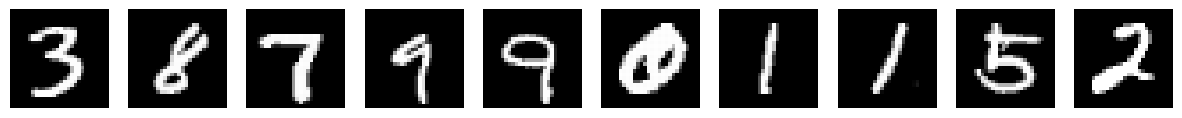

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [53]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

In [ ]:
## Helper functions

# Returns the purity of the clustering according to labels, 
# and the label counts of each cluster
def get_purity(labels, cluster_idx):
  nclasses = int(max(labels)+1)
  nidx = int(max(cluster_idx)+1)
  counts = np.zeros((nidx, nclasses), np.int32)
  for i in range(len(labels)):
    c = labels[i]
    idx = cluster_idx[i]
    counts[idx, c]+=1
  purity = np.sum(np.max(counts, axis=1))/len(cluster_idx)
  return purity, counts

# Returns an index list that can be used to re-order the counts according to 
# which label is most common 
def get_cluster_order(counts):
  idx = np.argmax(counts, axis=1)
  idx = np.argsort(idx)
  return idx 

###*Problem* 1.1 Clustering

k:  10
purity:  0.5995


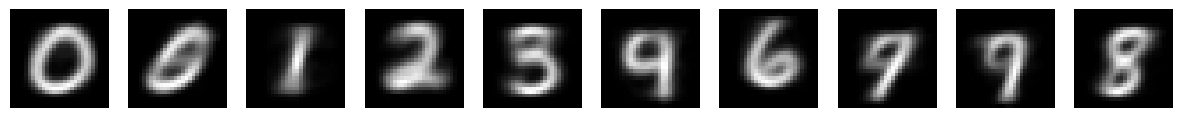

avg dist:  39.45538
k:  20
purity:  0.7209


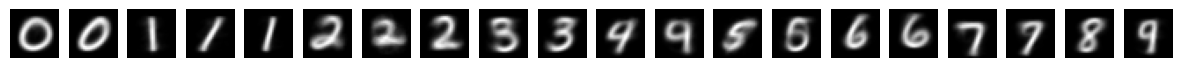

avg dist:  35.519306
k:  30
purity:  0.7748


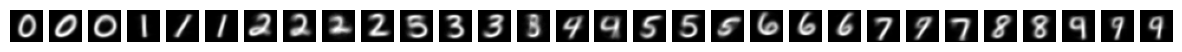

avg dist:  33.1933
k:  40
purity:  0.7766


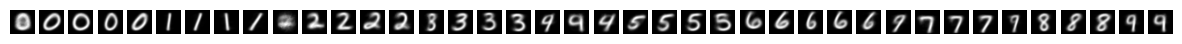

avg dist:  31.920824
k:  50
purity:  0.8009


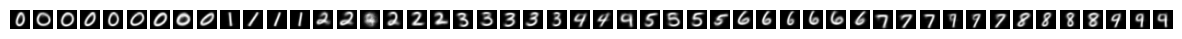

avg dist:  30.932173
k:  60
purity:  0.8296


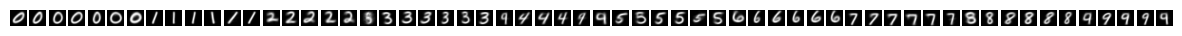

avg dist:  30.151546
k:  70
purity:  0.8501


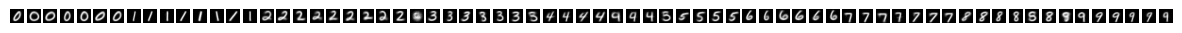

avg dist:  29.636063
k:  80
purity:  0.8662


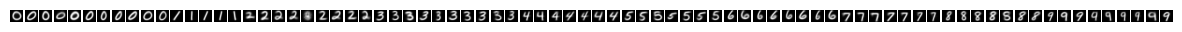

avg dist:  29.025084
k:  90
purity:  0.8736


avg dist:  28.604055
k:  100
purity:  0.8823


avg dist:  28.227947


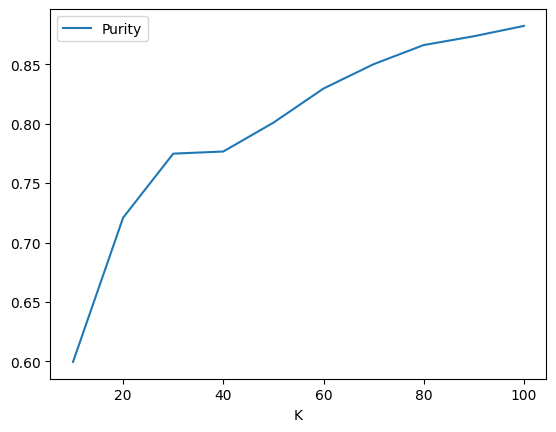

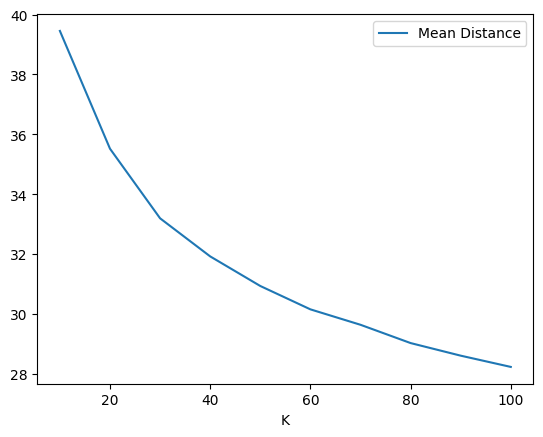

In [ ]:
# set dimensions
dim = x_train.shape[1]

# Set the number of clusters
clusters =  [10, 20, 30,40,50,60,70,80,90, 100]

purity_k = []
mean_k = []

for K in clusters:
  print('k: ', K)
  # Initialize the k-means clustering object
  kmeans = faiss.Kmeans(d=dim, k=K, niter=100, nredo=3, verbose=True)

  # Train the k-means model
  kmeans.train(x_train)

  # Assign each data point to a cluster
  dist, cluster_idx = kmeans.index.search(x_test, 1)

  # Record and print Purity
  purity, counts = get_purity(y_test, cluster_idx)
  purity_k.append(purity)
  print('purity: ', purity)
  
  #Get Cluster indexes & Display the centroids
  idx = get_cluster_order(counts)
  display_mnist(kmeans.centroids[idx, :],1,K)

  # Record and print Average Distance
  avg_dist = dist.mean()
  mean_k.append(avg_dist)
  print('avg dist: ', avg_dist)

#Plot K vs Purity and K vs Mean_Distances
plt.plot(clusters, purity_k, label='Purity')
plt.xlabel('K')
plt.legend()
plt.show()

plt.plot(clusters, mean_k, label='Mean Distance')
plt.xlabel('K')
plt.legend()
plt.show()

### Problem 1.2 Fast Retrieval

In [ ]:
## Brute Force (IndexFlatL2)

# set dimensions
dim = x_train.shape[1]
print('dim:', dim)

start_time = time.time()

# Initialize the index for Brute Force
index = faiss.IndexFlatL2(dim)

# Add Data & Print time to add
index.add(x_train)
print("Time to add data to Brute Force index: ", time.time()-start_time)

start_time = time.time()
# Perform Search and Compute Time required
dist, idx = index.search(x_test, 1)
print("Time taken for Brute Force search: ", time.time()-start_time)

# Compute Test Error
# test_error = np.mean(y_test.reshape(-1,1)[idx[idx < len(y_test)]] != y_test.reshape(-1,1))
# test_error = np.mean(y_test.reshape(-1,1)[idx] != y_test.reshape(-1,1))
test_error = np.mean(np.squeeze(y_test.reshape(-1,1)[idx[idx < len(y_test)]]) != y_test[idx[idx < len(y_test)]])
print("Test Error for Brute Force search: ", test_error)


dim: 784
Time to add data to Brute Force index:  0.2723705768585205
Time taken for Brute Force search:  13.150076627731323
Test Error for Brute Force search:  0.0


In [ ]:
## LSH

# set dimensions
dim = x_train.shape[1]

start_time = time.time()
# Initialize the index for LSH
nbits = 10
index = faiss.IndexLSH(dim, nbits)

# Add Data & Print time to add
index.add(x_train)
print("Time to add data to LSH index: ", time.time()-start_time)

start_time = time.time()
# Perform Search and Compute Time required
dist, idx = index.search(x_test, 1)
print("Time taken for LSH search: ", time.time()-start_time)

# Compute Test Error
# test_error = np.mean(y_test.reshape(-1,1)[idx[idx < len(y_test)]] != y_test.reshape(-1,1))
# test_error = np.mean(y_test.reshape(-1,1)[idx] != y_test.reshape(-1,1))
test_error = np.mean(np.squeeze(y_test.reshape(-1,1)[idx[idx < len(y_test)]]) != y_test[idx[idx < len(y_test)]])
print("Test Error for LSH search: ", test_error)


Time to add data to LSH index:  0.13391327857971191
Time taken for LSH search:  2.0145392417907715
Test Error for LSH search:  0.0


## Part 2: Estimating PDFs

In [1]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp5-10 amd64 1:10.0.0-4ubuntu1 [300 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-10-dev amd64 1:10.0.0-4ubuntu1 [47.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libomp-dev amd64 1:10.0-50~exp1 [2,824 B]
Fetched 351 kB in 0s (2,614 kB/s)
Selecting previously unselected package libomp5-10:amd64.
(Reading database ... 122400 files and directories currently installed.)
Preparing to unpack .../libomp5-10_1%3a10.0.0-4ubuntu1_amd6

In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Mounted at /content/drive


In [3]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

#### Method 1 (Per-dimension discrete pdf)

In [4]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  # TO DO: 
  # (1) loop through values
  for val in x:
  # (2) increment element of p corresponding to each value
    p[int(val)] += 1# p[val] += 1
  # (3) divide by sum of p
  p /= np.sum(p)    
  return p

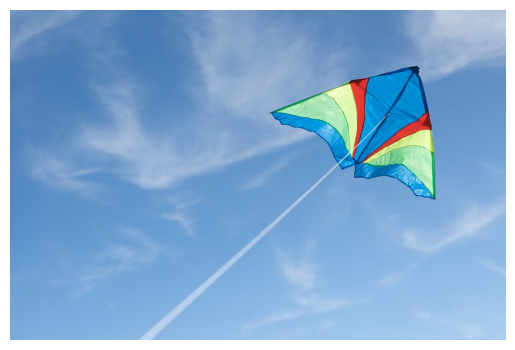

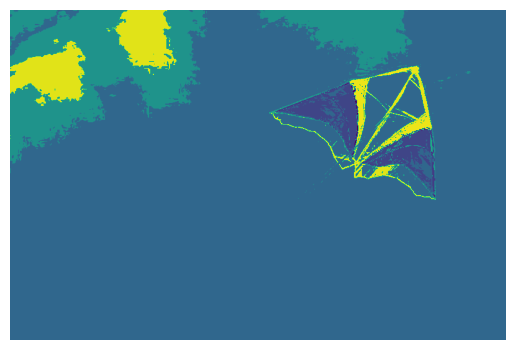

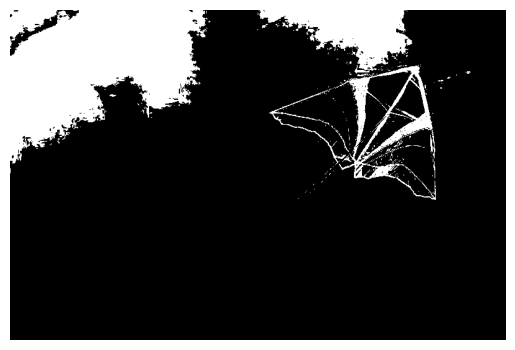

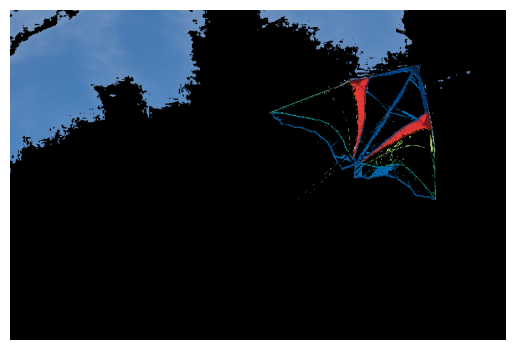

In [14]:
# set number of bins K
K = 4

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
discrete_im_pixels = np.minimum(np.floor(im_pixels * K).astype(int), K-1)
discrete_crop_pixels = np.minimum(np.floor(crop_pixels * K).astype(int), K-1)

# get pdf for each dimension using estimate_discrete_pdf
pdf_im = np.ones((K, K, K))
pdf_crop = np.ones((K, K, K))
for i in range(3):
    pdf_im[:,:,i] = estimate_discrete_pdf(discrete_im_pixels[:,i], K)
    pdf_crop[:,:,i] = estimate_discrete_pdf(discrete_crop_pixels[:,i], K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
        score_map[i, j] = np.log(pdf_crop[rgbi] / pdf_im[rgbi])


# display
display_score_maps(im, score_map, thresh=0)


#### Method 2 (K-means)

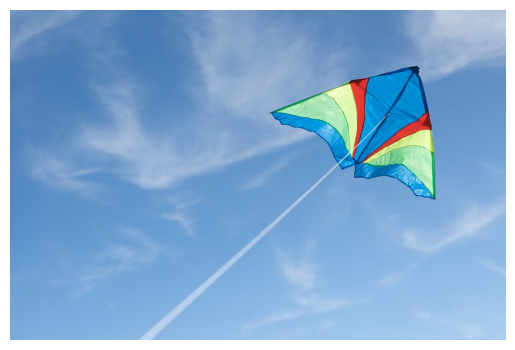

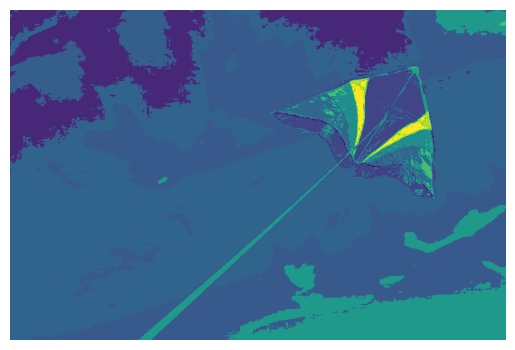

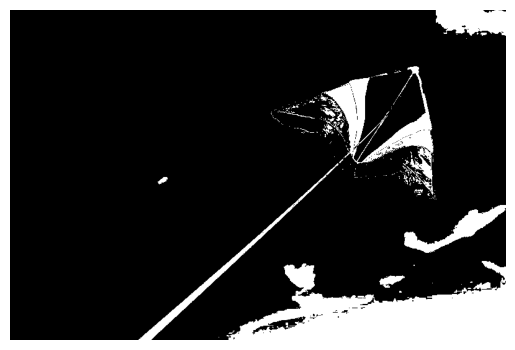

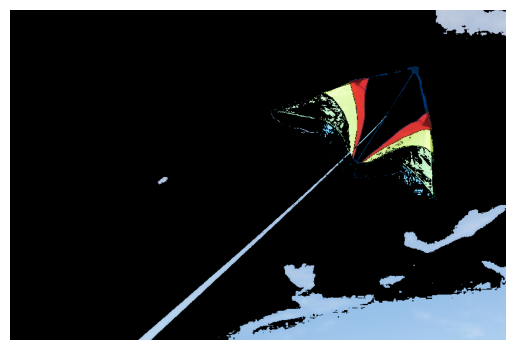

In [25]:
import faiss

# set K
K = 8

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# discretize all three color channels together using KMeans
# kmeans = faiss.Kmeans(d=dim, k=K, niter=100, nredo=3, verbose=True)
kmeans_im = faiss.Kmeans(d=im_pixels.shape[1], k=K)
kmeans_crop = faiss.Kmeans(d=crop_pixels.shape[1], k=K)
kmeans_im.train(im_pixels)
kmeans_crop.train(crop_pixels)

# get pdf over discrete values
pdf_im = np.ones((K, K, K))
pdf_crop = np.ones((K, K, K))
for i in range(3):
    pdf_im[:,:,i] = estimate_discrete_pdf(kmeans_im.centroids[:,i], K)
    pdf_crop[:,:,i] = estimate_discrete_pdf(kmeans_crop.centroids[:,i], K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
        score_map[i, j] = np.log(kmeans_crop.centroids[rgbi[0]][0] * kmeans_crop.centroids[rgbi[1]][1] * kmeans_crop.centroids[rgbi[2]][2] / 
                                  (kmeans_im.centroids[rgbi[0]][0] * kmeans_im.centroids[rgbi[1]][1] * kmeans_im.centroids[rgbi[2]][2]))

# display
display_score_maps(im, score_map, thresh=0)

#### Method 3 (GMM)

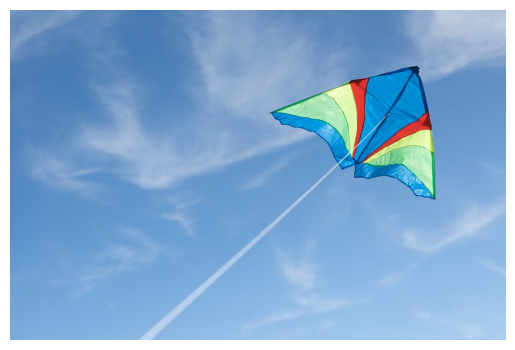

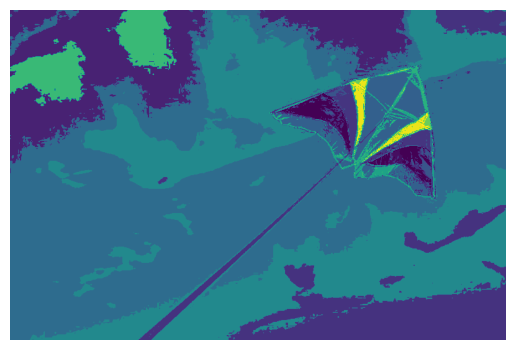

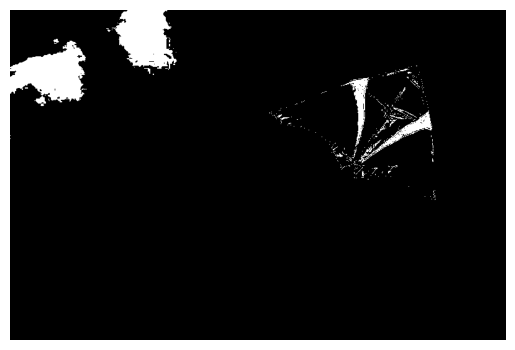

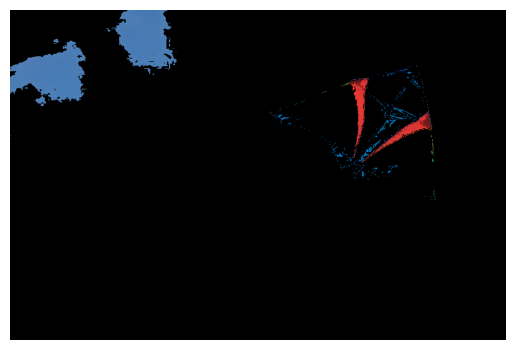

In [27]:
from sklearn.mixture import GaussianMixture
n_components = 7
cov_type = 'full'

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# get joint pdf using GMMs (choose number of components and other parameters)
gmm_im = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=0).fit(im_pixels)
gmm_crop = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=0).fit(crop_pixels)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
  for j in range(im.shape[1]):
    rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
    score_map[i, j] = np.log(gmm_crop.score_samples([rgbi]) / gmm_im.score_samples([rgbi]))

# display
display_score_maps(im, score_map, thresh=0)

## Part 3: PCA and Data Compression

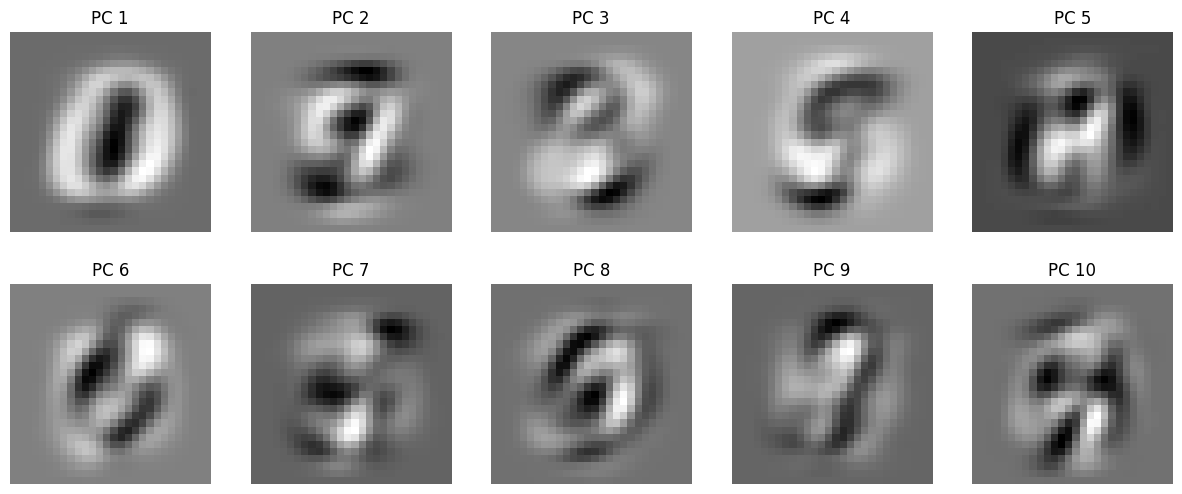

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import faiss
from sklearn.metrics import accuracy_score

(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

# Compute the principal components using x_train
pca = PCA()
pca.fit(x_train)

# Display First 10 Components
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()):
    if i < 10:
        ax.imshow(pca.components_[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.show()


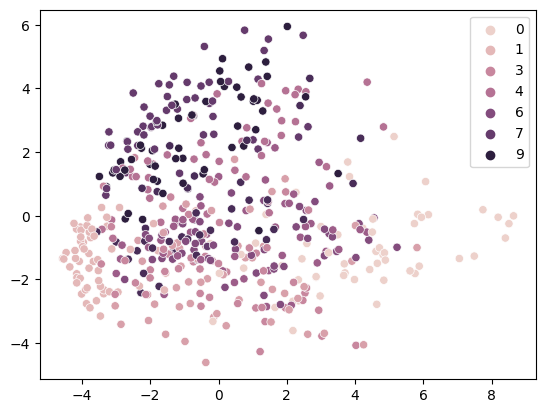

In [55]:
# Scatter plot of first two PCA dimensions
import seaborn as sns  #sns.scatterplot(x, y, hue=labels)

pca_2d = PCA(n_components=2)
x_train_pca_2d = pca_2d.fit_transform(x_train[train_indices['s']])
sns.scatterplot(x=x_train_pca_2d[:,0], y=x_train_pca_2d[:,1], hue=y_train[train_indices['s']])
plt.show()

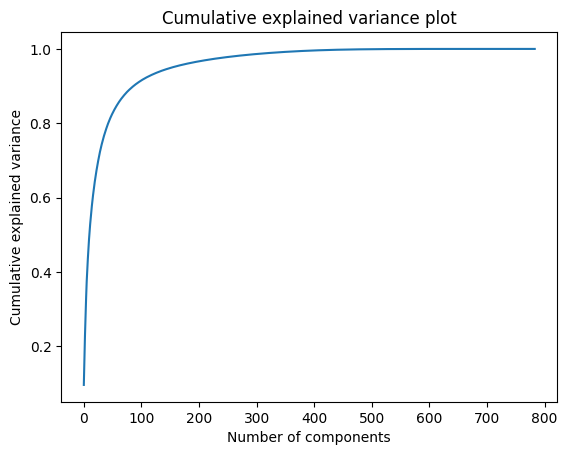

In [ ]:
# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance plot')
plt.show()

Smallest number of principal components that explains at least 90% of variance:  88
Time to add data to the index:  0.01834273338317871
Time to perform search:  1.791013479232788
Test error:  0.029000000000000026


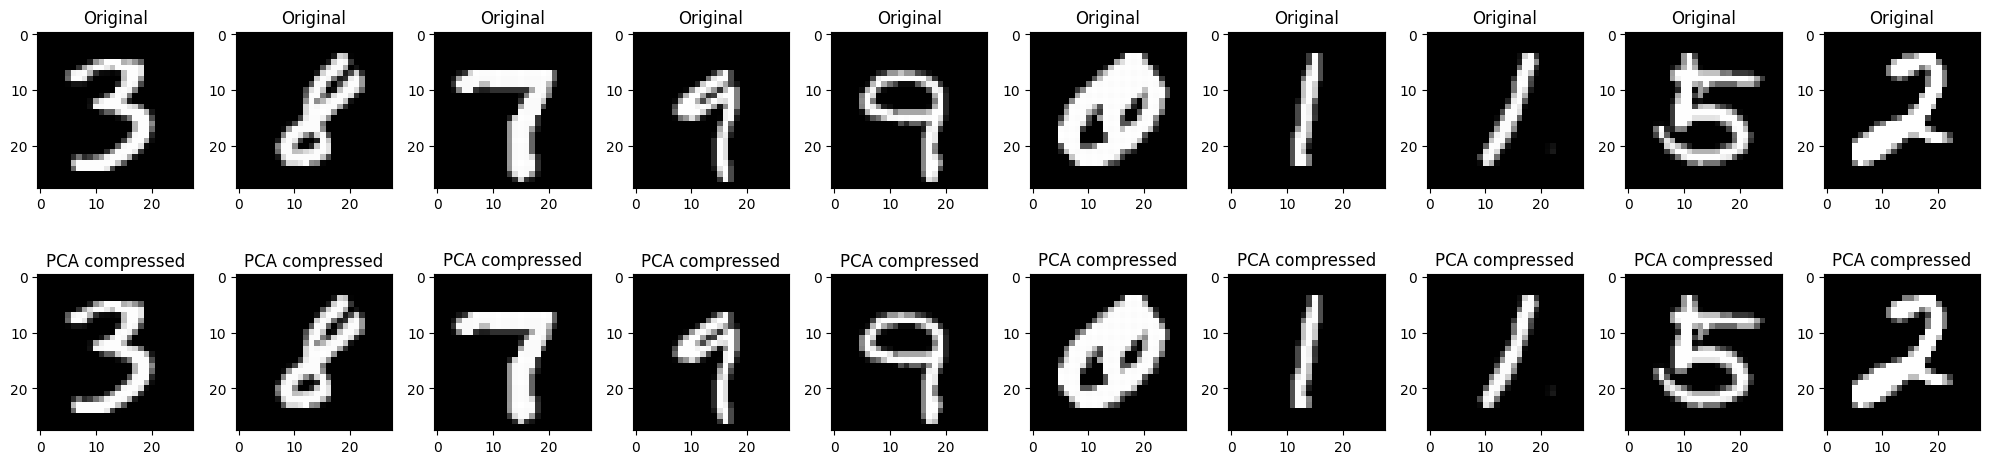

In [ ]:
# Select number of dimensions that explains 90% of variance, according to your plot above
cumsum_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum_variance_ratio >= 0.9) + 1
print('Smallest number of principal components that explains at least 90% of variance: ', dim)


# Display thfig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i, ax in enumerate(axes.T):
    ax[0].imshow(x_train[i].reshape(28, 28), cmap='gray')  # Reshape to 2D array before displaying
    ax[1].imshow(pca.inverse_transform(pca.transform(x_train[i].reshape(1, -1))).reshape(28, 28), cmap='gray')
    ax[0].set_title('Original')
    ax[1].set_title('PCA compressed')
plt.tight_layout()

pca_90 = PCA(n_components=dim)

# Initialize the index for Brute Force
index = faiss.IndexFlatL2(88)

# Add Data & Print time to add
x_train_pca = pca_90.fit_transform(x_train)
start_time = time.time()
index.add(x_train_pca)
print('Time to add data to the index: ', time.time() - start_time)


# Perform Search and Compute Time required
k = 1  # number of nearest neighbors to search for
x_test_pca = pca_90.transform(x_test)
# start_time = time.time()
dist, idx = index.search(x_test_pca, k)
print('Time to perform search: ', time.time() - start_time)


# Compute Test Error
test_error = 1 - accuracy_score(y_test, y_train[idx.flatten()])
print('Test error: ', test_error)


## Part 4: Stretch Goals
Include all your code used for part 4 in this section. You can copy-paste code from parts 1, 2 or 3 if it is re-usable.

## part 4-1

In [45]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + '3985783648_4702b45d13_c.jpg')

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + '3985783648_4702b45d13_c_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

In [48]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  # TO DO: 
  # (1) loop through values
  for val in x:
  # (2) increment element of p corresponding to each value
    p[int(val)] += 1# p[val] += 1
  # (3) divide by sum of p
  p /= np.sum(p)    
  return p

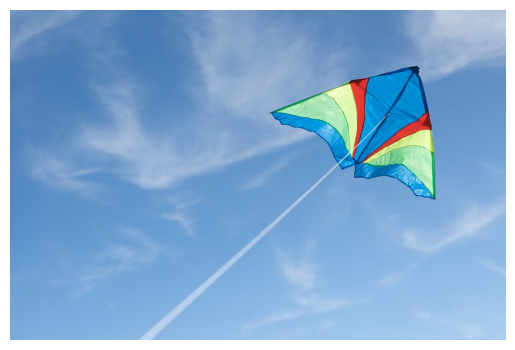

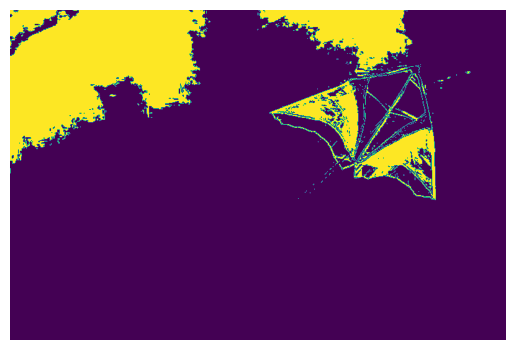

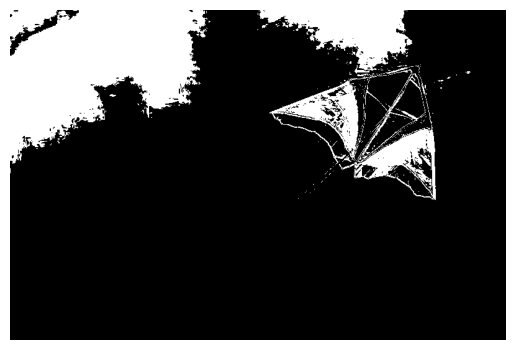

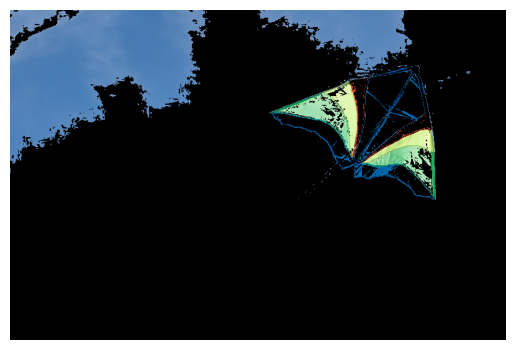

In [49]:
from sklearn.decomposition import PCA

# set number of bins K
K = 4
n_components = 3

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
discrete_im_pixels = np.minimum(np.floor(im_pixels * K).astype(int), K-1)
discrete_crop_pixels = np.minimum(np.floor(crop_pixels * K).astype(int), K-1)

# apply PCA to both images
pca_im = PCA(n_components=n_components)
pca_im.fit(im_pixels)
pca_crop = PCA(n_components=n_components)
pca_crop.fit(crop_pixels)

# transform the images to the PCA space
im_pca = pca_im.transform(im_pixels)
crop_pca = pca_crop.transform(crop_pixels)

# get pdf for each dimension using estimate_discrete_pdf
pdf_im = np.ones((K, K, K))
pdf_crop = np.ones((K, K, K))
for i in range(3):
    pdf_im[:,:,i] = estimate_discrete_pdf(im_pca[:,i], K)
    pdf_crop[:,:,i] = estimate_discrete_pdf(crop_pca[:,i], K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
        score_map[i, j] = np.log(pdf_crop[rgbi] / pdf_im[rgbi])

# display
display_score_maps(im, score_map, thresh=0)


## part 4-2

In [28]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (1:10.0-50~exp1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2

drive.mount('/content/drive')
datadir = "/content/drive/My Drive/CS441/hw4/" # revise as needed
im = cv2.imread(datadir + 'peakpx.jpg')

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255  # converts to RGB ordering and values between 0 and 1
crop = cv2.imread(datadir + 'peakpx_crop.jpg')
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
def display_score_maps(im, score_map, thresh):
  '''
    Input: im (h, w, 3): RGB image
           score_map (h, w, 1) or (h*w, 1)
           thresh: floating point threshold, typically between -2 and 2
  '''
  plt.imshow(im)
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map, (im.shape[:2])))
  plt.axis('off')
  plt.show()
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)
  plt.axis('off')
  plt.show()

#### Method 1 (Per-dimension discrete pdf)

In [31]:
# estimate discrete pdf
def estimate_discrete_pdf(x, K, prior=1):
  '''
    Input: x(nx, ): an array of discrete values from 0 to K-1
           K: number of possible discrete values
           prior: initial count for each discrete value
    Output: p(nvalues, ): p[i] is the estimated probability of discrete value i
    
    This function can be used for Method 1 and Method 2
  '''

  p = np.ones(K,)*prior # initialize p 
  # TO DO: 
  # (1) loop through values
  for val in x:
  # (2) increment element of p corresponding to each value
    p[int(val)] += 1# p[val] += 1
  # (3) divide by sum of p
  p /= np.sum(p)    
  return p

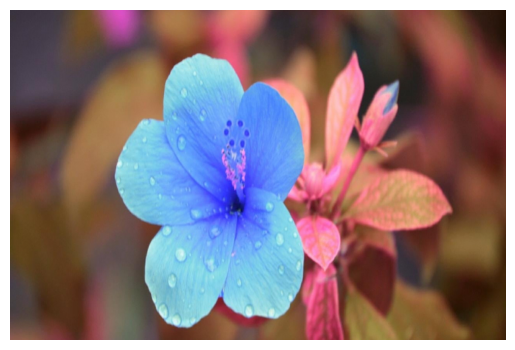

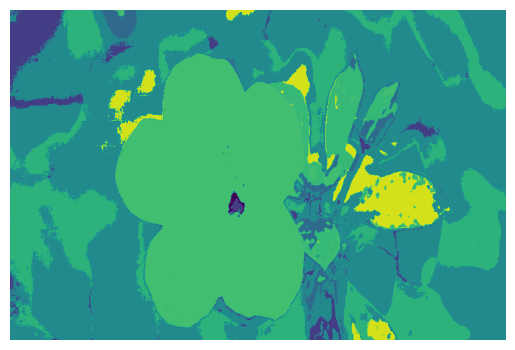

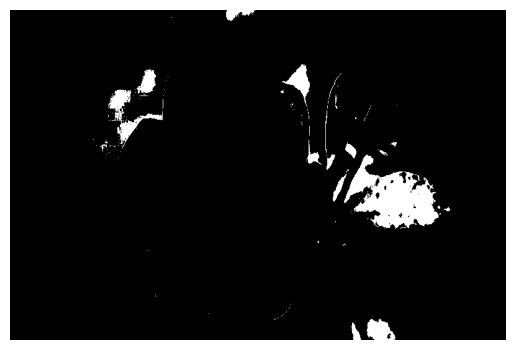

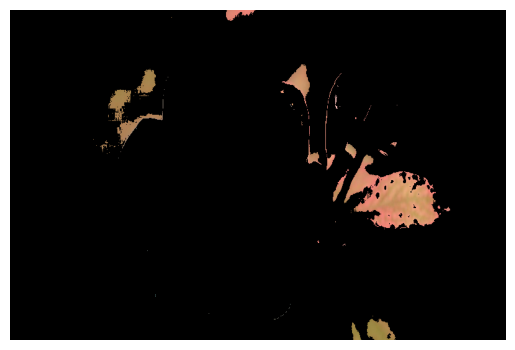

In [37]:
# set number of bins K
K = 4

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# convert continuous values to discrete values ranging from 0 to K-1 
# e.g. x-->min(int(x*K), K-1) if x ranges from 0 to 1
discrete_im_pixels = np.minimum(np.floor(im_pixels * K).astype(int), K-1)
discrete_crop_pixels = np.minimum(np.floor(crop_pixels * K).astype(int), K-1)

# get pdf for each dimension using estimate_discrete_pdf
pdf_im = np.ones((K, K, K))
pdf_crop = np.ones((K, K, K))
for i in range(3):
    pdf_im[:,:,i] = estimate_discrete_pdf(discrete_im_pixels[:,i], K)
    pdf_crop[:,:,i] = estimate_discrete_pdf(discrete_crop_pixels[:,i], K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
        score_map[i, j] = np.log(pdf_crop[rgbi] / pdf_im[rgbi])


# display
display_score_maps(im, score_map, thresh=0)


#### Method 2 (K-means)

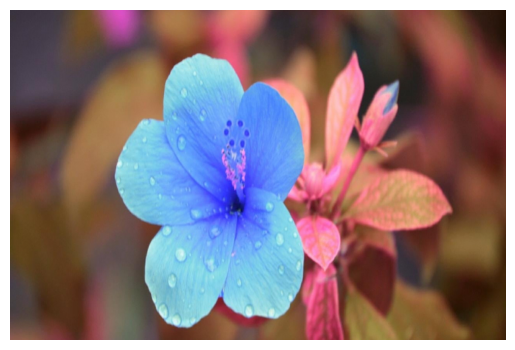

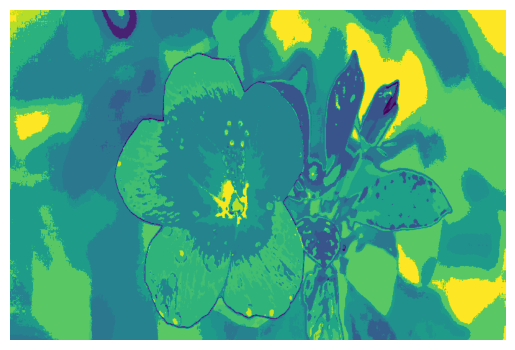

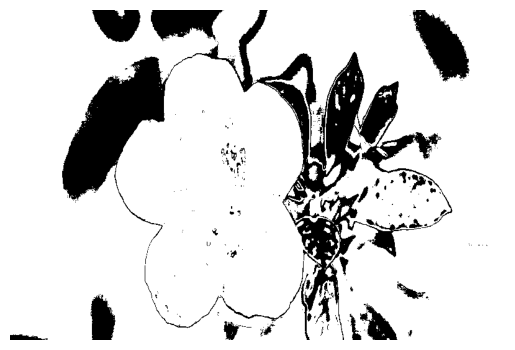

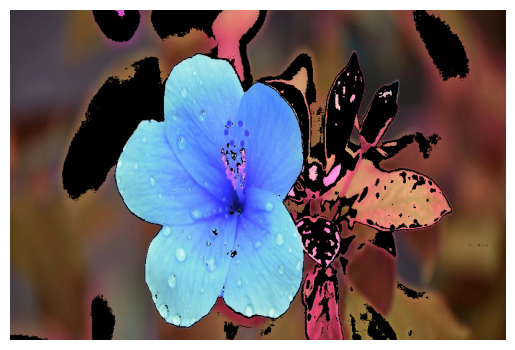

In [44]:
import faiss

# set K
K = 16

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# discretize all three color channels together using KMeans
# kmeans = faiss.Kmeans(d=dim, k=K, niter=100, nredo=3, verbose=True)
kmeans_im = faiss.Kmeans(d=im_pixels.shape[1], k=K)
kmeans_crop = faiss.Kmeans(d=crop_pixels.shape[1], k=K)
kmeans_im.train(im_pixels)
kmeans_crop.train(crop_pixels)

# get pdf over discrete values
pdf_im = np.ones((K, K, K))
pdf_crop = np.ones((K, K, K))
for i in range(3):
    pdf_im[:,:,i] = estimate_discrete_pdf(kmeans_im.centroids[:,i], K)
    pdf_crop[:,:,i] = estimate_discrete_pdf(kmeans_crop.centroids[:,i], K)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
        score_map[i, j] = np.log(kmeans_crop.centroids[rgbi[0]][0] * kmeans_crop.centroids[rgbi[1]][1] * kmeans_crop.centroids[rgbi[2]][2] / 
                                  (kmeans_im.centroids[rgbi[0]][0] * kmeans_im.centroids[rgbi[1]][1] * kmeans_im.centroids[rgbi[2]][2]))

# display
display_score_maps(im, score_map, thresh=0)

#### Method 3 (GMM)

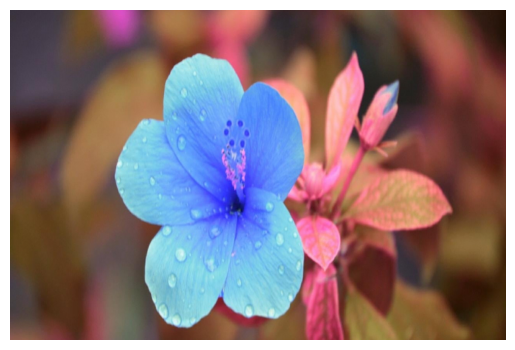

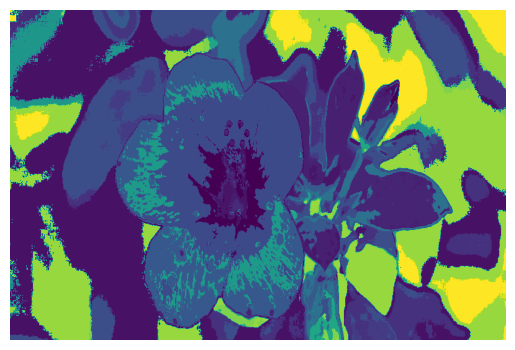

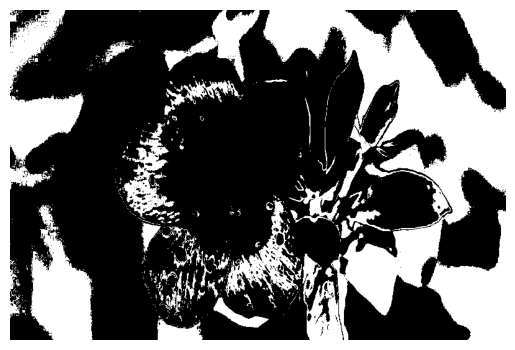

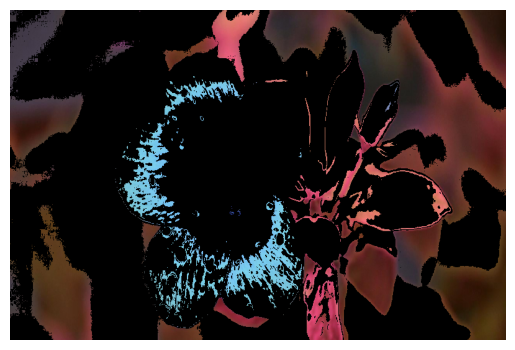

In [34]:
from sklearn.mixture import GaussianMixture
n_components = 7
cov_type = 'full'

# reshape pixels to (h*w, 3)
im_pixels = im.reshape((-1, 3))
crop_pixels = crop.reshape((-1, 3))

# get joint pdf using GMMs (choose number of components and other parameters)
gmm_im = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=0).fit(im_pixels)
gmm_crop = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=0).fit(crop_pixels)

# estimate score for each pixel in full image according to log pdfs
score_map = np.zeros((im.shape[0], im.shape[1], 1))
for i in range(im.shape[0]):
  for j in range(im.shape[1]):
    rgbi = tuple(discrete_im_pixels[i*im.shape[1]+j]) # extract (r, g, b) tuple
    score_map[i, j] = np.log(gmm_crop.score_samples([rgbi]) / gmm_im.score_samples([rgbi]))

# display
display_score_maps(im, score_map, thresh=0)

## part 4-3

In [56]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import time
import faiss
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images (can print 1 row OR 1 column)
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  s = np.ceil(max(subplot_rows, subplot_cols)/10)
  if subplot_rows>1 or subplot_cols>1:
      fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
      for i in range(len(x)):
        ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
        ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

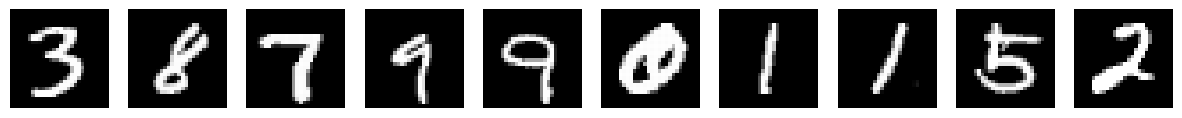

Total size: train=50000, val=10000, test =10000
Train subset size: xs=50, s=500, m=5000, all=50000
Class count for s: [56 57 51 49 46 46 50 51 40 54]


In [57]:
# example of using MNIST load, display, indices, and count functions
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()
display_mnist(x_train[:10],1,10)
print('Total size: train={}, val={}, test ={}'.format(len(x_train), len(x_val), len(x_test)))
print('Train subset size: xs={}, s={}, m={}, all={}'.format(len(train_indices['xs']),len(train_indices['s']),len(train_indices['m']),len(train_indices['all'])))
print('Class count for s: {}'.format(class_count_mnist(y_train[train_indices['s']])))

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
<ipython-input-60-aa09b28ea4f7>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_data[:, 0], pca_data[:, 1], cmap='viridis') #c=train_indices,
<ipython-input-60-aa09b28ea4f7>:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_data[:, 0], tsne_data[:, 1],  cmap='viridis') #c=train_indices['s'],
<ipython-input-60-aa09b28ea4f7>:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mds_data[:, 0], mds_data[:, 1],  cmap='viridis') #c=train_indices['s'],


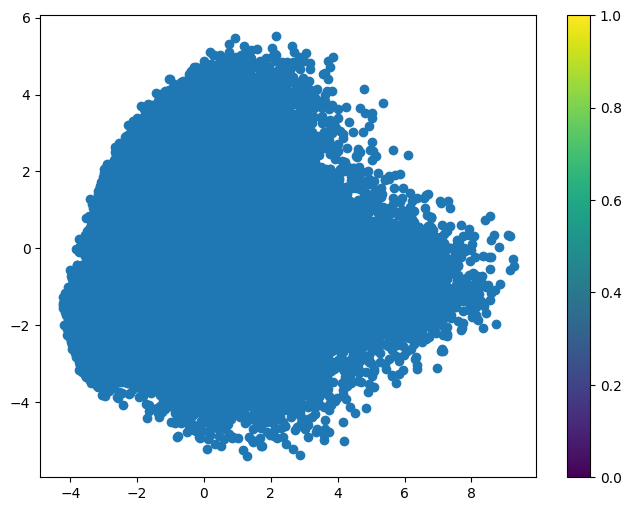

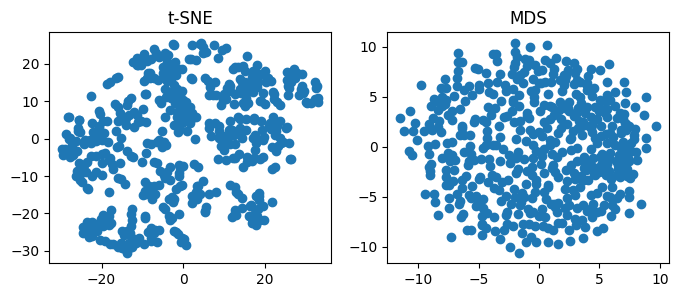

In [60]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

# Define the subset of data to plot using the 's' index
s_data = x_train[train_indices['s']]

# Run PCA on the full dataset
pca = PCA(n_components=2)
pca_data = pca.fit_transform(x_train)

# Run additional dimensionality reduction methods on the subset of data
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(s_data)

mds = MDS(n_components=2)
mds_data = mds.fit_transform(s_data)

# lda = LDA(n_components=2)
# lda_data = lda.fit_transform(s_data)

# Plot the PCA scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], cmap='viridis') #c=train_indices,
plt.colorbar()

# Plot the t-SNE and MDS scatterplots
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1],  cmap='viridis') #c=train_indices['s'],
plt.title('t-SNE')

plt.subplot(122)
plt.scatter(mds_data[:, 0], mds_data[:, 1],  cmap='viridis') #c=train_indices['s'],
plt.title('MDS')

# # Plot the LDA scatterplot
# plt.figure(figsize=(8, 3))
# plt.scatter(lda_data[:, 0], lda_data[:, 1], c=train_indices['s'], cmap='viridis')
# plt.title('LDA')

plt.show()
